# Simulation of a Healthy Control

A TVB dataset for healthy control is used along with assumed epileptogenicity parameters that are "stable" and non-epileptic.

We analyze the neural fragility of this dataset and compute what is our negative-control (i.e. no epilepsy at all).

In [1]:
import numpy as np
import pandas as pd
import mne
from pprint import pprint

import os
import json
import os.path as op
from pathlib import Path
import collections

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pydmd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

from mne_features.univariate import compute_spect_slope
from mne_features.utils import power_spectrum

from eztrack.io.base import _add_desc_to_bids_fname
from eztrack.io import read_derivative_npy
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

import sys
sys.path.append('../../')
from sickkids.dmd.dmd import rescale_modes
from sickkids.posthoc.spectral import compute_significant_freqs, compute_bootstrap_lr
from sickkids.tvb.simulation import load_subject_connectivity, setup_simulation


_load_turbo()

# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

2020-12-02 19:54:53,798 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [6]:
# paths to data
root = Path('/Users/adam2392/Dropbox/resection_tvb/sourcedata/')
experimental_condition = 'control'
subject = 'CON01T1'
# subject = 'CON11T2'

subj_path = root / experimental_condition / subject
source_file = subj_path / f'{subject}_TVB.zip'

print(source_file.exists())

True


# Load Connectivity Data

We will load a preprocessed TVB connectivity dataset, which contains:

- areas.txt = The surface area in mm^3 of each region parcellation
- average_orientations.txt = The 3D orientation of each region parcellation
- centres.txt = The 3D centroid of each region
- cortical.txt = A binary flag of which region(s) are part of the cortical surface (others are part of the subcortical surface)
- tract_lengths.txt = The pairwise tract lengths matrix between all regions
- weights.txt = The pairwise weight matrix between all regions

In most of our datasets, these will be constructed from a `Desikan` atlas, which comprises of 84 distinct brain regions.

In [7]:
conn = load_subject_connectivity(
    source_file=str(source_file), condspeed=3.
)

WARNING  File 'hemispheres' not found in ZIP.


In [8]:
# show the summary for this subject
print(conn.number_of_regions)

0


<ipython-input-9-42e25eb72286>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')


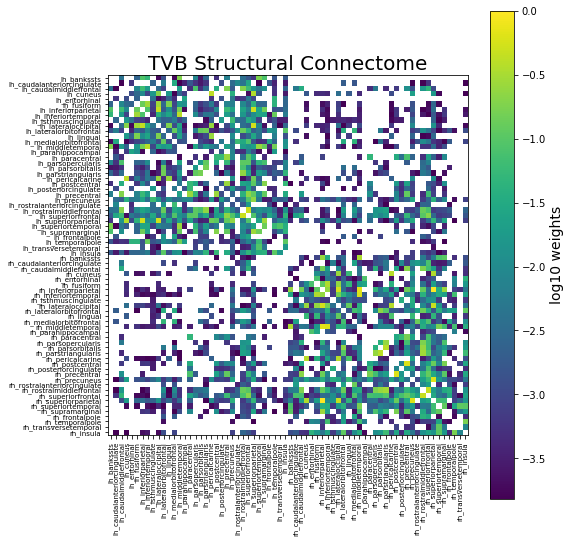

In [9]:
nregions = len(conn.region_labels)
# Visualization.
plt.figure(figsize=(8,8))
plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), conn.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), conn.region_labels, fontsize=7)
cb=plt.colorbar(
#     shrink=0.8
)
cb.set_label('log10 weights', fontsize=14)
plt.tight_layout()
plt.show()

# Load in Channel Coordinates

Channel coordinates in 3D brain space should have been localized on a CT image and then coregistred and mapped to the brain space that the connectivity data was constructed from. This is generally derived from FreeSurfer.

In [10]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [11]:
experimental_condition = 'epilepsy'
subject_ = 'id013_pg'

subj_path = root / experimental_condition / subject_

In [12]:

# first load in the channel's xyz coordinates
ch_xyz_fpath = subj_path / 'elec' / 'seeg.txt'

seeg_pd = pd.read_csv(
    ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

ch_names = seeg_pd.index.values
ch_xyz = seeg_pd.to_numpy()
ch_pos = seeg_pd.T.to_dict(orient='list')

In [13]:
# got all the channels!
print(ch_names)
pprint(take(5, ch_pos.items()))

['TB1' 'TB2' 'TB3' 'TB4' 'TB5' 'TB6' 'TB7' 'TB8' 'TB9' 'A1' 'A2' 'A3' 'A4'
 'A5' 'A6' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'OT1'
 'OT2' 'OT3' 'OT4' 'OT5' 'OT6' 'OT7' 'OT8' 'OT9' 'C1' 'C2' 'C3' 'C4' 'C5'
 'C6' 'PI1' 'PI2' 'PI3' 'PI4' 'PI5' 'PI6' 'PI7' 'PI8' 'PI9' 'OP1' 'OP2'
 'OP3' 'OP4' 'OP5' 'OP6' 'OP7' 'OP8' 'OP9']
[('TB1', [37.37, 0.03, -34.55]),
 ('TB2', [40.87, 0.18, -34.49]),
 ('TB3', [44.36, 0.32, -34.43]),
 ('TB4', [47.86, 0.47, -34.37]),
 ('TB5', [51.35, 0.62, -34.31])]


# Initialize Epileptor Models At Brain Regions

In [14]:
if subject == 'id013_pg':
    ez_label = ['ctx-rh-fusiform']
    pz_label = ['Right-Hippocampus', 'Right-Amygdala', 
                'ctx-rh-middltemporal', 'ctx-rh-inferiortemporal',
                'ctx-rh-entorhinal'] 
elif subject == 'id008_gc':
    ez_label = ['Right-Amygdala', 'Right-Hippocampus']
    pz_label = ['ctx-rh-superiortemporal', 'ctx-rh-middletemporal', 
                'ctx-rh-inferiortemporal', 'ctx-rh-medialorbitofrontal',
                'ctx-rh-temporalpole',
                'ctx-rh-lateralorbitofrontal'
               ]
else:
    ez_label = None
    pz_label = None

In [15]:
if subject in ['id013_pg', 'id008_gc']:
    # read in the ez hypothesis regions
    with open(subj_path / 'tvb' / 'ez_hypothesis.txt', 'r') as fin:
        ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
    print(ez_hypo)
    ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

    # get the hypothesized EZ and PZ
    ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
    ez_regions = conn.region_labels[ezhypo_inds]

    pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
    pz_regions = conn.region_labels[pzhypo_inds]

    print(ez_regions, pz_regions)

## Get Stable Initial Conditions

In [16]:
from tvb.simulator.models.epileptor import Epileptor
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
from tvb.simulator.lab import cortex, local_connectivity

In [35]:
sim = setup_simulation(
    conn, ch_xyz, 
#     gain_fname=str(gain_inv_fname),
#     ezind=ezhypo_inds, 
    variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'],
    r=0.00035 / 7, tt=0.1, x0norm=-2.40,
    seeg_fname=str(ch_xyz_fpath),
)

Computing simple gain mat!
[<tvb.simulator.monitors.TemporalAverage object at 0x135833d30>, <tvb.simulator.monitors.iEEG object at 0x135833640>]
   INFO  Projection configured gain shape (59, 68)


In [36]:
(times, epilepts), (_, seegts) = sim.run(simulation_length=1000)

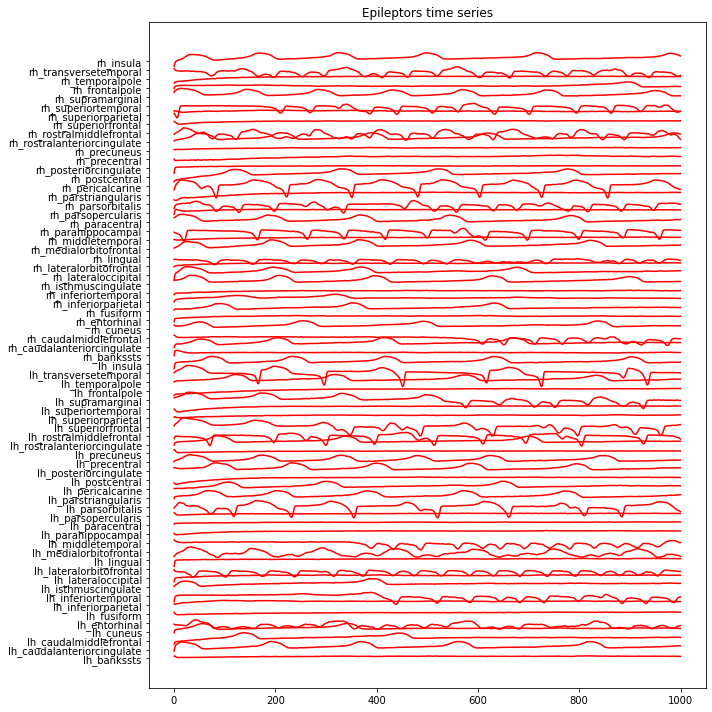

In [37]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, -1, :, 0] / (np.max(epilepts[:, -1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

In [38]:
# note that there are now 7 state variables
# the first 6 are part of the Epileptor fast/slow/veryslow subsystems 
# the last 1 is the actual time series that is projected to the sEEG electrode locations
print(epilepts.shape)


(1000, 7, 68, 1)


In [39]:
# we store the initial conditions as a 6x1 array
init_cond = epilepts[-1, :-1, :, :][np.newaxis, ...]
print(init_cond.shape)

# re-run simulation and check that initial conditions worked
sim = setup_simulation(
    conn, ch_xyz, 
#     gain_fname=str(gain_inv_fname),
    x0norm=-2.4,
    variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'],
    r=0.00035 / 7, tt=0.1, initial_conditions=init_cond,
    seeg_fname=str(ch_xyz_fpath)
)

(times, epilepts), (_, seegts) = sim.run(simulation_length=1000)

(1, 6, 68, 1)
Computing simple gain mat!
[<tvb.simulator.monitors.TemporalAverage object at 0x135300160>, <tvb.simulator.monitors.iEEG object at 0x1353007f0>]
   INFO  Projection configured gain shape (59, 68)


In [40]:
# create a file path to save initial conditions to
output_path = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb')
output_path.mkdir(exist_ok=True, parents=True)
bids_path = BIDSPath(subject=subject, session='preresection', task='initialconditions', suffix='epileptor',
                     extension='.npy', check=False)
initial_cond_fpath = output_path / bids_path.basename

print(initial_cond_fpath)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/sub-CON01T1_ses-preresection_task-initialconditions_epileptor.npy


In [41]:
# save initial conditions into a numpy array
np.save(initial_cond_fpath, init_cond)
print(f'Saved initial conditions to: {initial_cond_fpath}')

Saved initial conditions to: /Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/sub-CON01T1_ses-preresection_task-initialconditions_epileptor.npy


In [42]:
initial_conditions = np.load(initial_cond_fpath)
print(initial_conditions.shape)

(1, 6, 68, 1)


In [43]:
print(epilepts.shape, seegts.shape)

(1000, 7, 68, 1) (1000, 1, 59, 1)


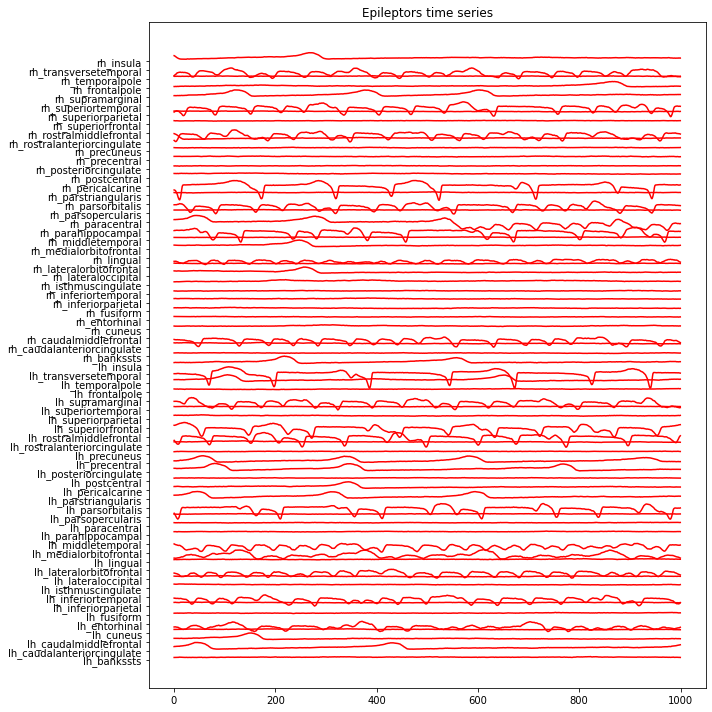

In [44]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, -1, :, 0] / (np.max(epilepts[:, -1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

# Setup Final Simulation Object

In [45]:
sim = setup_simulation(
    conn, ch_xyz, 
    initial_conditions=initial_conditions,
    x0norm=-2.40, r=0.00035 / 7, tt=0.1, 
    seeg_fname=ch_xyz_fpath
)

Computing simple gain mat!
[<tvb.simulator.monitors.TemporalAverage object at 0x135db2a90>, <tvb.simulator.monitors.iEEG object at 0x1355d10d0>]
   INFO  Projection configured gain shape (59, 68)


In [46]:
print(sim)

Simulator (
  Type ................................ Simulator
  conduction_speed .................... 3.0
  connectivity ........................ Connectivity gid: dc83b7e3-3658-4b98-bf3a-d94a5a6d3eef
  coupling ............................ Difference gid: e53561c2-b351-4d87-9514-9b7c8ce1d4c6
  gid ................................. UUID('57cfccbe-ec7b-4176-a78f-4d9ed15df016')
  initial_conditions [min, median, max]  [-23.2604, -0.15918, 4.92336]
  initial_conditions dtype ............ float64
  initial_conditions shape ............ (1, 6, 68, 1)
  integrator .......................... HeunStochastic gid: 39a218f4-6d88-44ee-88b4-2cc1b0aafdfc
  model ............................... Epileptor gid: b917e27e-6898-4a74-9ae5-19bafe5de6a2
  monitors ............................ [<tvb.simulator.monitors.TemporalAverage object at 0x135db2a90>, <tvb.simulator.monitors.iEEG object at 0x1355d10d0>]
  simulation_length ................... 1000.0
  stimulus ............................ None
  surface

# Run Simulation

In [47]:
sim_length = 30000
(times, epilepts), (_, seegts) = sim.run(
        simulation_length=sim_length)

In [48]:
seeg = seegts.copy()
tavg = epilepts.copy()

In [49]:
# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)

In [50]:
print(len(conn.region_labels))
print(epilepts.shape)
print(epilepts[:, 0, :, 0].max(axis=0).shape)
print(seegts.shape)

68
(30000, 2, 68, 1)
(68,)
(30000, 1, 59, 1)


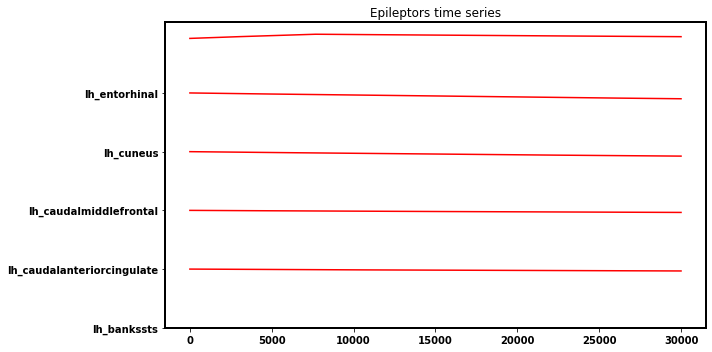

In [66]:
#Plot raw time series
plt.figure(figsize=(10,5))
nregions =  len(conn.region_labels)
nregions = 5
plt.plot(times[:], epilepts[:, 0, 0:5, 0] / epilepts[:, 0, 0:5, 0].max(axis=0) + np.r_[:5], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

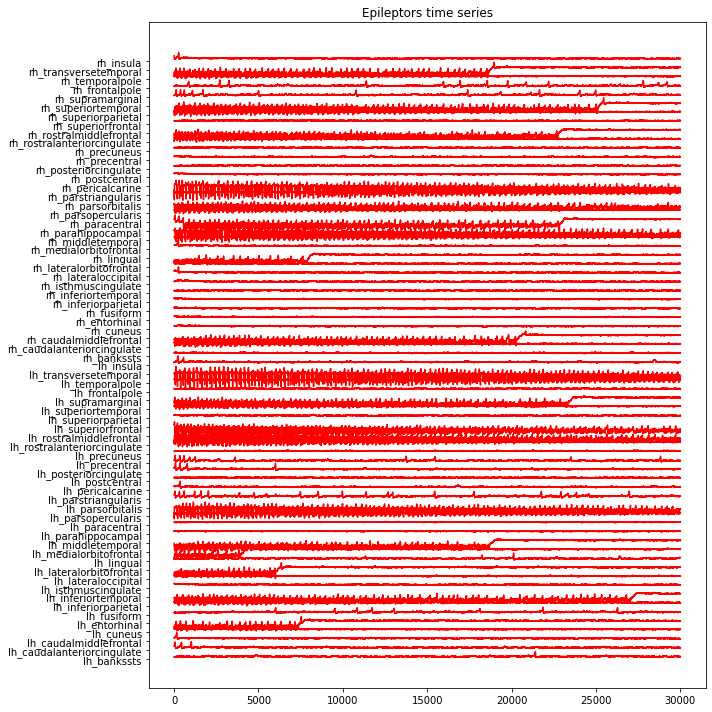

In [52]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, 1, :, 0] / (np.max(epilepts[:, 1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'SEEG')

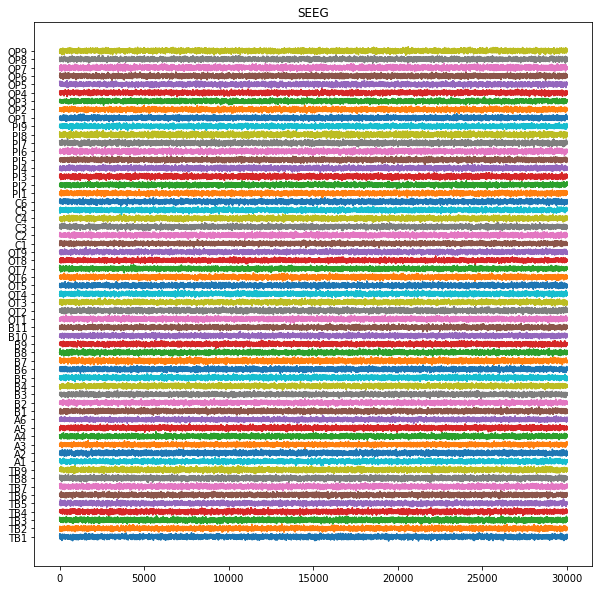

In [53]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg[:, 0, :len(ch_names), 0] + np.r_[:len(ch_names)])
plt.yticks(np.r_[:len(ch_names)], ch_names[:len(ch_names)])
plt.title("SEEG")

In [54]:
# make sure subject doesn't have '_' character
subject = subject.replace('_', '')
print(subject)

# save data and the sEEG projections
bids_path = BIDSPath(subject=subject, session='preresection', task='tvbsim', suffix='ieeg', run='01',
                     extension='.npz', check=False)
print(bids_path.basename)

output_path = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb')
output_path.mkdir(exist_ok=True, parents=True)

CON01T1
sub-CON01T1_ses-preresection_task-tvbsim_run-01_ieeg.npz


In [55]:
np.savez_compressed(output_path / bids_path.basename, 
                   epilepts=epilepts, seegts=seegts, 
                    times=times,
                   ch_names=ch_names, region_names=conn.region_labels)

## Fragility analysis of the original data

In [56]:
with np.load(output_path / bids_path.basename, allow_pickle=True) as data_dict:
    data_dict = dict(data_dict)
    print(data_dict.keys())

epilepts = data_dict['epilepts']
seeg = data_dict['seegts']
times = data_dict['times']
ch_names = data_dict['ch_names']
region_names = data_dict['region_names']

dict_keys(['epilepts', 'seegts', 'times', 'ch_names', 'region_names'])


In [57]:
seegdata = seeg[:, 0, ...].squeeze().T * 1e-6
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=ch_names.tolist(), ch_types='seeg')
raw = RawArray(seegdata, info=info)

(59, 30000)


In [58]:
print(seeg.min())

-0.7274344833816988


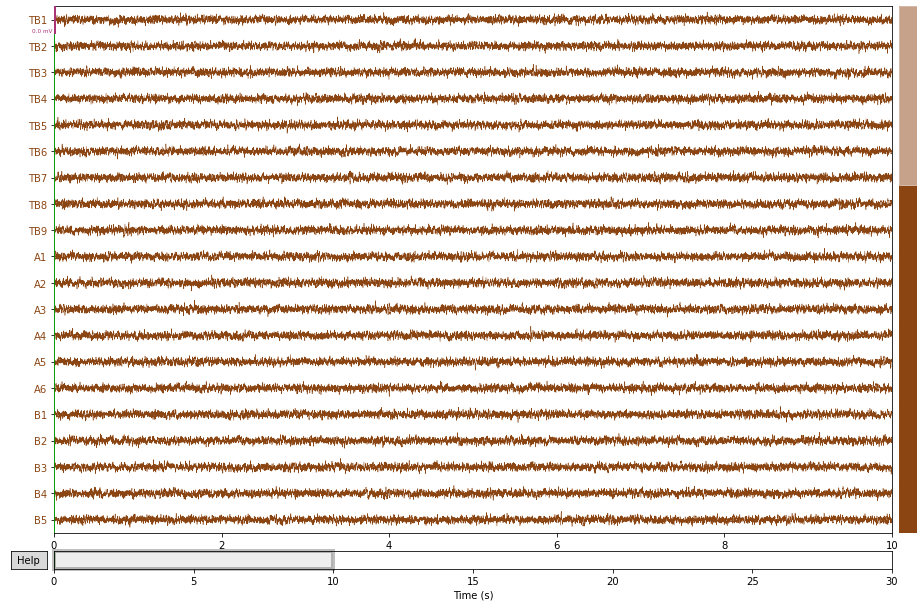

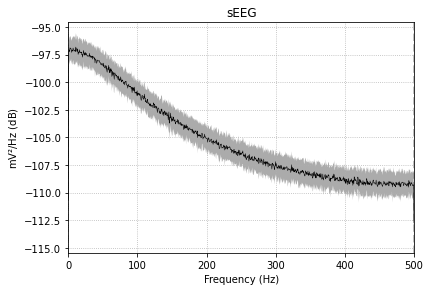

This is the raw simulated data


In [59]:
raw.plot(scalings={'seeg': 1e-6})

raw.plot_psd( average=True)
print('This is the raw simulated data')

In [60]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

<RawArray | 59 x 30000 (30.0 s), ~13.6 MB, data loaded>


In [61]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(raw, reference='monopolar', return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using pinv least squares with l2penalty 0.
Data matrix shape input: (59, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=0, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=1.5, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:10<00:00, 22.63eeg window/s]


(59,) (59, 59) (59, 59)


/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

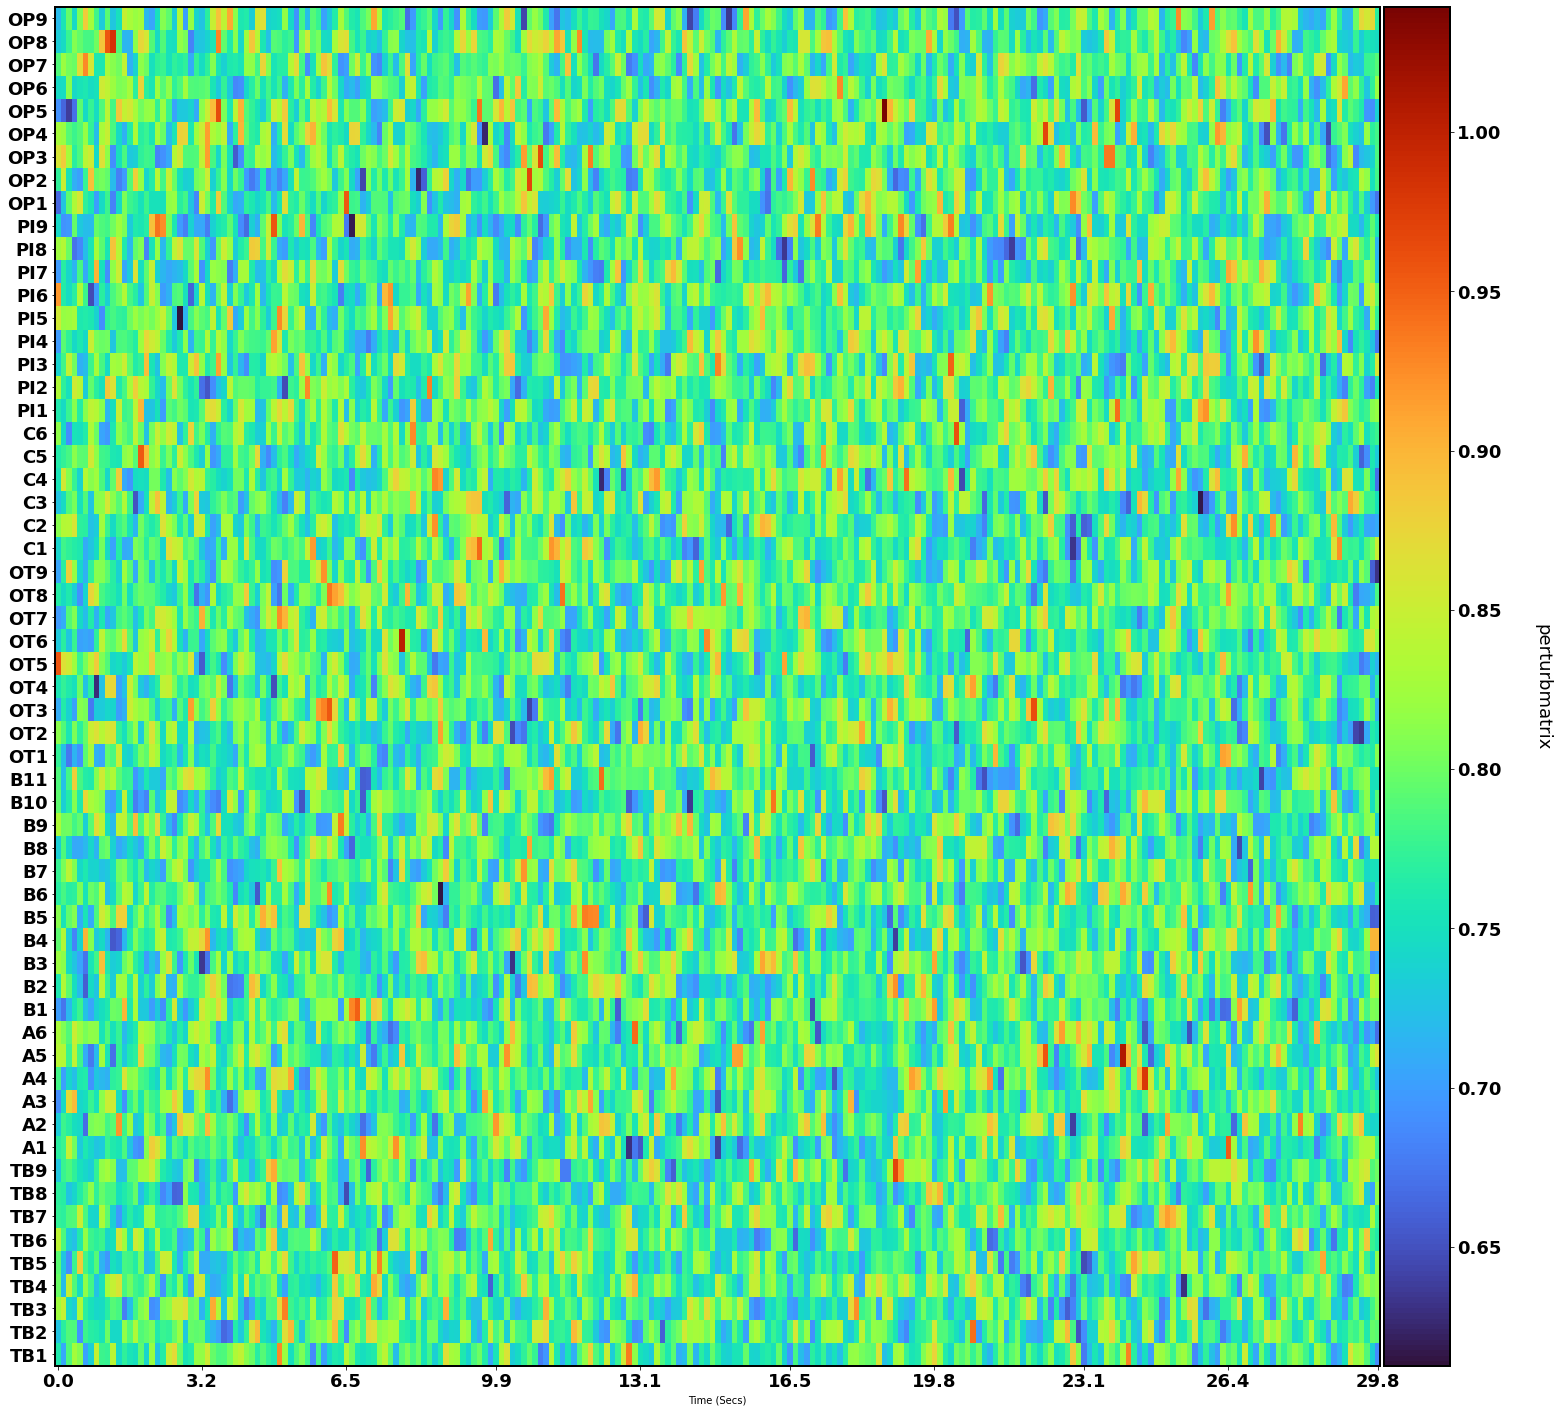

In [62]:
pert_deriv.plot_heatmap()

<DerivativeArray | None, shape: (59, 239) (59 chs x 239 times) (29.8 s), ~224 kB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

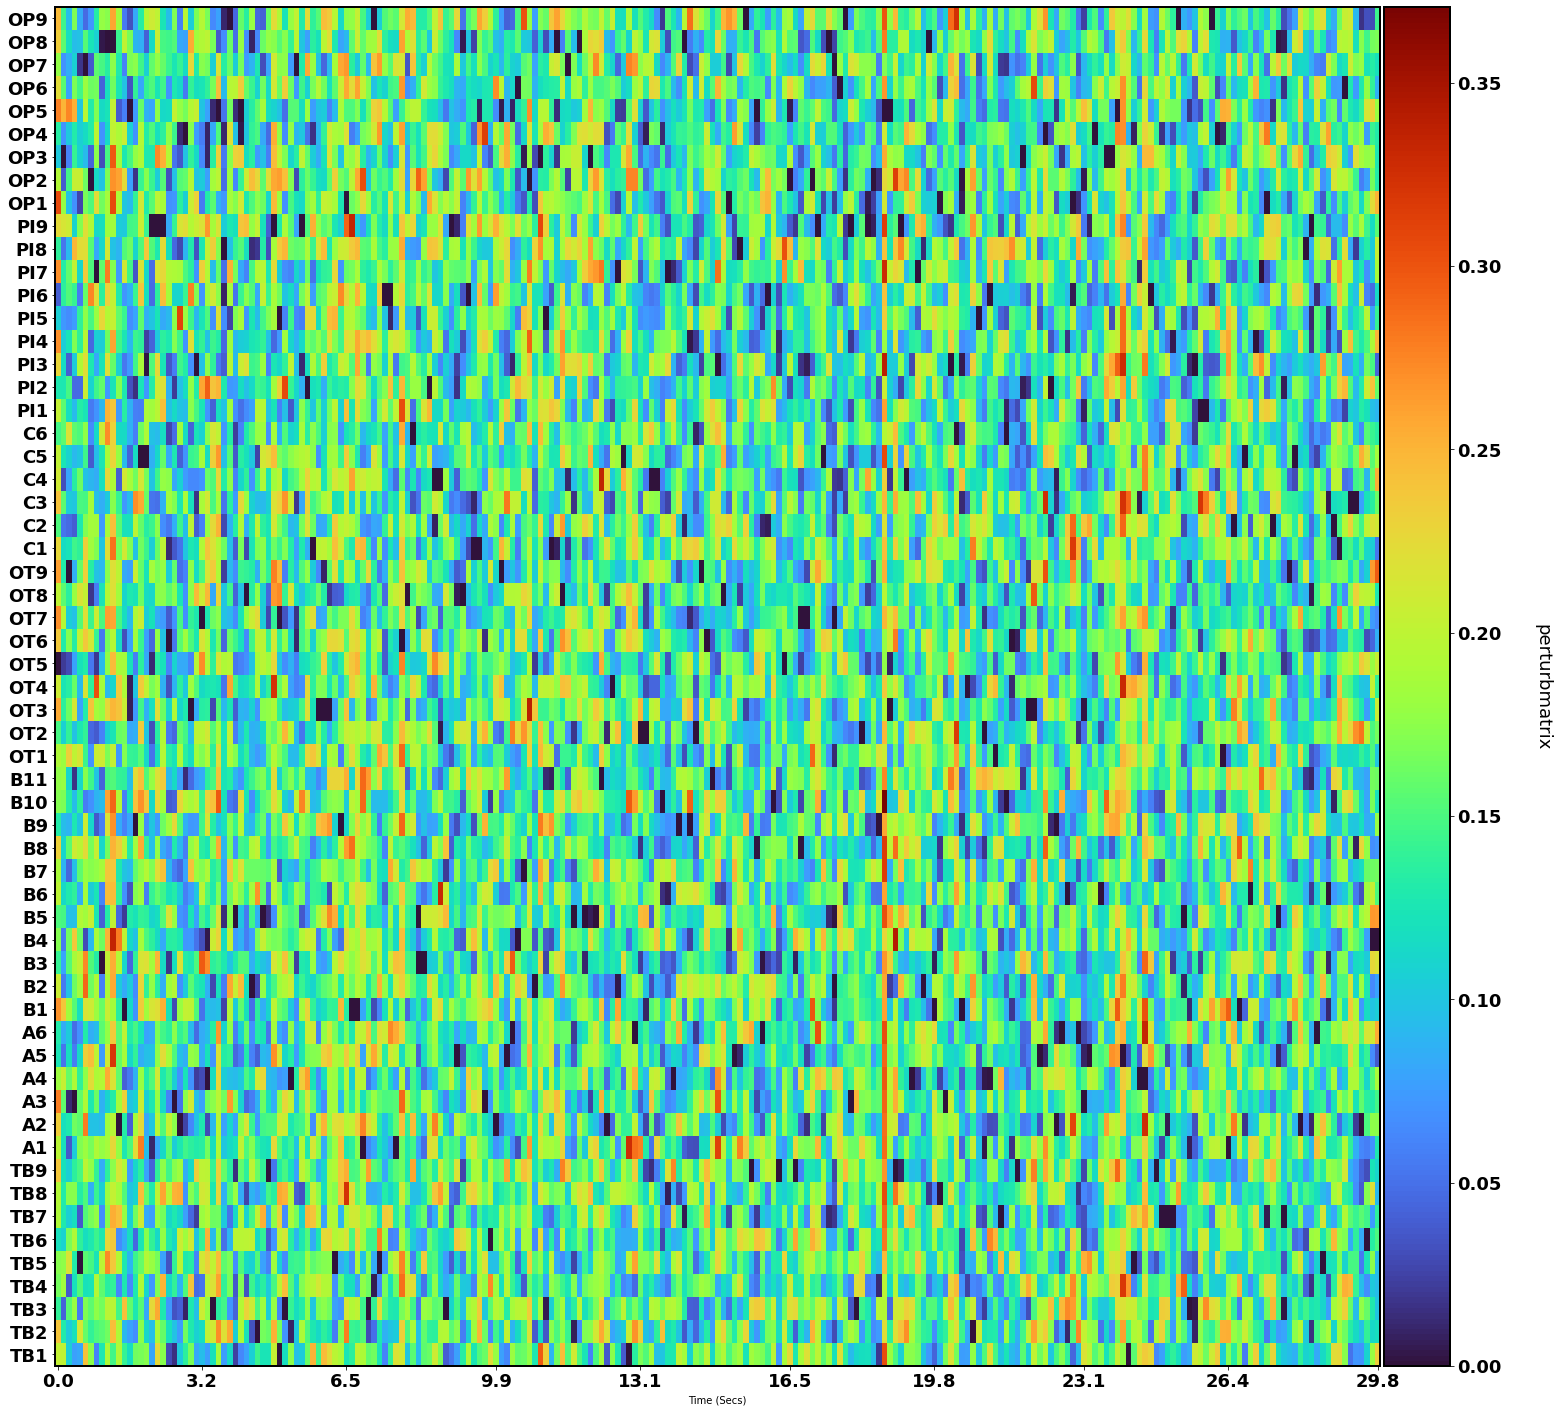

In [63]:
pert_deriv_copy = pert_deriv.copy()
pert_deriv_copy.normalize()
pert_deriv_copy.plot_heatmap()